<a href="https://colab.research.google.com/github/Almonok/AttaCoeurs/blob/main/Adversarial_Attacks_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project is about adversarial attacks.

## Outline of the project 


1.   Building a classifier on CIFAR-10
2.   Implementing various adversarial attacks
3.   Building adversarial training
4.   Comparing various adversarial training strategies with various attacks





## Importing modules and setting notebook parameters

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!git clone https://github.com/MarinaChau/AttaCoeurs.git

Cloning into 'AttaCoeurs'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 86 (delta 35), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (86/86), done.


In [ ]:
%cd AttaCoeurs

/content/AttaCoeurs


In [ ]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from AttaCoeurs.src import adversarial_attacks as attacks
from AttaCoeurs.src import custom_model as models

# Building a simple CIFAR-10 classifier.

Here, we create a neural network for image classification on the CIFAR-10 dataset.
First, we download and instanciate the CIFAR-10 dataset.

In [ ]:
# Load Cifar dataset from keras
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess
x_train = tf.constant(x_train.reshape(50000,32, 32,3).astype("float32") / 255)
x_test = tf.constant(x_test.reshape(10000, 32, 32, 3).astype("float32") / 255)

y_train = tf.constant(y_train.astype("float32"))
y_test = tf.constant(y_test.astype("float32"))

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [ ]:
# Parameters for the architecture of convolutional neural networks
class CnnParams(object):
    def __init__(self):
        # Model hyperparameters
        self.input_shape = [32, 32, 3]
        self.num_classes = 10
        self.num_conv_filters = [64, 64, 32, 32]
        self.kernel_size = (3, 3)
        self.pool_size = (2, 2)
        self.num_fc_units = [512]

        self.epochs = 40
        self.batch_size = 32
        
cnn_params = CnnParams()


def get_cnn_model(adv_training_with=None, name="cnn_model"):
    """
    Returns a CustomModel for adversarial training.
    """

    # Define Model layers
    inputs = tf.keras.Input(shape=cnn_params.input_shape,
                            dtype=tf.float32, name="image")

    x = inputs
    
    # Convolutional layer followed by MaxPool and Dropout regularization layers
    for i, num_filters in enumerate(cnn_params.num_conv_filters):
        x = tf.keras.layers.Conv2D(num_filters,
                                   cnn_params.kernel_size,
                                   padding='same',
                                   activation='relu',
                                   name=f"Conv{i}")(x)
        if i < len(cnn_params.num_conv_filters) - 1:
            # Max pooling + Dropout
            x = tf.keras.layers.MaxPooling2D(cnn_params.pool_size)(x)
            x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Flatten()(x)

    for i, num_units in enumerate(cnn_params.num_fc_units):
        x = tf.keras.layers.Dense(num_units,
                                  activation='relu',
                                  name=f"Dense{i}")(x)

    pred = tf.keras.layers.Dense(cnn_params.num_classes, activation='softmax')(x)
    
    # CustomModel instanciates a Keras model.
    return models.CustomModel(inputs=inputs, 
                              outputs=pred, 
                              adv_training_with=adv_training_with,
                              name=name)

Building and compiling the model

In [ ]:
# Building model
model = get_cnn_model(adv_training_with=None, 
                      name="BaseModel")

# Compiling model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

model.summary()

Model: "BaseModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 Conv1 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                     

Training without adversary examples. Code for training is commented, instead we load a pre_trained model from github.

In [ ]:
print(f"Building {model.name},{model.training_info}")

# Uncomment for training
# model.fit(x_train, y_train,
#           batch_size=cnn_params.batch_size,
#           epochs=cnn_params.epochs,
#           validation_data=(x_test, y_test)
#           )
model.load_weights("pre_train/BaseModel_40_epochs.h5")

Building BaseModel, trained without adversarial examples


Evaluating the model on clean test dataset.

In [ ]:
metrics = model.evaluate(x_test, y_test)
print("Accuracy : {:.3f}".format(metrics[1]))

313/313 [==============================] - 11s 4ms/step - loss: 0.6976 - acc: 0.7583
Accuracy : 0.758


# 3. Implementing adversarial attacks

## 3.1. FGSM

Setting parameter values

In [ ]:
eps_values = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.8, 1]
print(f"epsilon values : {eps_values}")

epsilon values : [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.8, 1]


In [ ]:
fgsm_params = {"eps_values": eps_values}

In [ ]:
accuracies = []
for eps in eps_values:
  attack = attacks.Fgsm(model, eps=eps)
  x_corrupted = attack(x_test[:200], y_test[:200])
  
  acc = model.evaluate(x_corrupted, y_test[:200], verbose=False)
  print("eps = {:.2f} -- Accuracy : {:.3f}".format(eps, acc[1]))
  accuracies.append(acc[1])

eps = 0.01 -- Accuracy : 0.550
eps = 0.01 -- Accuracy : 0.355
eps = 0.05 -- Accuracy : 0.045
eps = 0.10 -- Accuracy : 0.050
eps = 0.15 -- Accuracy : 0.080
eps = 0.20 -- Accuracy : 0.100
eps = 0.30 -- Accuracy : 0.125
eps = 0.50 -- Accuracy : 0.140
eps = 0.80 -- Accuracy : 0.175
eps = 1.00 -- Accuracy : 0.175


Text(0.5, 1.0, 'Hyperparameter search for FGSM attack')

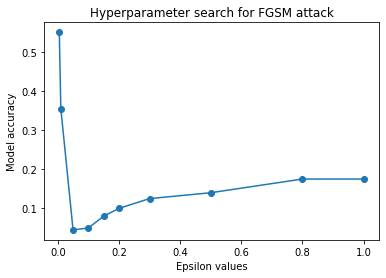

In [ ]:
plt.plot(eps_values, accuracies, marker="o")
plt.xlabel("Epsilon values")
plt.ylabel("Model accuracy")
plt.title("Hyperparameter search for FGSM attack")

We notice that $\epsilon = 0.1$ gives the best performances.

## 3.2. PGD

## 3.3. DeepFool

DeepFool requires no hyperparameters. However, for practical concerns, we restrict the number of iterations to a fixed value.

In [ ]:
deepfool = attacks.DeepFool(model, num_iter=100)
x_corrupted = deepfool(x_test[:200], y_test[:200])
acc = model.evaluate(x_corrupted, y_test[:200], verbose=False)

print("Accuracy : {:.3f}".format(acc[1]))

Tensor
Attacking image 0/200...


TypeError: ignored

Visualizing DeepFool attacks

Attacking image 0/20...
Attacking image 1/20...
Attacking image 2/20...
Attacking image 3/20...
Attacking image 4/20...
Attacking image 5/20...
Attacking image 6/20...
Attacking image 7/20...
Attacking image 8/20...
Attacking image 9/20...
Attacking image 10/20...
Attacking image 11/20...
Attacking image 12/20...
Attacking image 13/20...
Attacking image 14/20...
Attacking image 15/20...
Attacking image 16/20...
Attacking image 17/20...
Attacking image 18/20...
Attacking image 19/20...


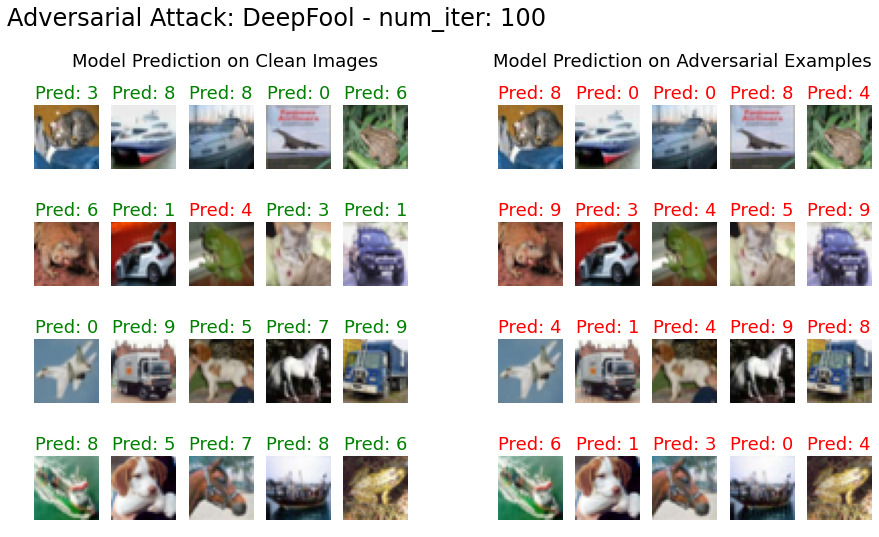

In [ ]:
attack_kwargs = {"num_iter": 100}
attacks.attack_visual_demo(model,
                           attacks.DeepFool,
                           attack_kwargs,
                           x_test[:20],
                           y_test[:20])

As we can see, the perturbations are very hard to notice.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


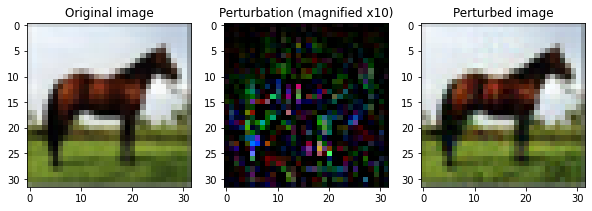

In [ ]:
rd_id = np.random.randint(len(x_test))
example = (x_test[rd_id], y_test[rd_id])
xs, r_tot = deepfool.fool(*example)
f, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(x_test[rd_id])
ax[1].imshow(r_tot*10)
ax[2].imshow(xs[-1])

ax[0].set_title("Original image")
ax[1].set_title("Perturbation (magnified x10)")
ax[2].set_title("Perturbed image")

plt.show()

# 4. Adversarial Training

The goal of adversarial training is to try to build models that are more robust against adversarial attacks. In order to perform adversarial training, one adds adversarial examples to the training process to inform the neural network that classification should be invariant inside a ball of fixed radius.

## 4.1. Adversarial training with DeepFool

In [ ]:
# Set adversarial training parameters
eps = 0.031
num_iter = 40

attack_kwargs = {
                 "num_iter": num_iter}

adv_training_with = {"attack": attacks.DeepFool,
                     "attack kwargs": attack_kwargs,
                     "num adv": 16}

# Build model
cnn_model_pgd = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_pgd.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
cnn_model_pgd.run_eagerly = True

# Train model
cnn_model_pgd.fit(x_train, y_train,
                   batch_size=32,epochs=20,
                   validation_split=0.2)

[autoreload of AttaCoeurs.src.adversarial_attacks failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/content/AttaCoeurs/src/adversarial_attacks.py", line 171
    def _body(i, predicted_label)
      ^
SyntaxError: invalid syntax
]


Epoch 1/20
Tensor
Attacking image 0/32...


TypeError: ignored